# 🚀 Classification Multi-Classes avec Transfer Learning

Ce notebook présente un pipeline complet de classification d'images utilisant **EfficientNetV2B0** avec transfer learning.

## 📋 Table des Matières
1. [Installation des Dépendances](#dependencies)
2. [Chargement et Préparation des Données](#data)
3. [Visualisation des Données](#visualization)
4. [Architecture du Modèle](#model)
5. [Entraînement](#training)
6. [Évaluation des Performances](#evaluation)
7. [Sauvegarde du Modèle](#save)
8. [Tests de Prédiction](#prediction)

## 🎯 Objectif
Développer un classifieur capable de reconnaître **32 classes d'objets** différentes avec une précision élevée en utilisant des techniques de transfer learning.

---

## 1. Installation des Dépendances {#dependencies}


In [10]:
!pip install -q kagglehub tensorflow

## 2. Chargement et Préparation des Données {#data}

Nous utilisons le dataset **Image Classification - 32 Classes** de Kaggle qui contient des images de 32 catégories différentes.

### 🔍 Caractéristiques du Dataset:
- **12,155 images** au total
- **32 classes** différentes (animaux, objets, nourriture, etc.)
- Images de taille variable (redimensionnées à 224x224)
- Distribution: 80% entraînement, 10% v

In [11]:
import kagglehub
import os

print("⬇️ Accès au jeu de données en cours...")

# Dans un environnement Kaggle, kagglehub.dataset_download retourne directement
# le chemin vers le dossier déjà décompressé.
# Il n'y a donc pas besoin de décompresser.
data_dir = kagglehub.dataset_download("anthonytherrien/image-classification-dataset-32-classes")
# Ligne à ajouter
data_dir = os.path.join(data_dir, 'image')
print(f"Chemin d'accès corrigé : {data_dir}")
print(f"✅ Le jeu de données est directement accessible à l'emplacement : {data_dir}")

# Vérifions le contenu pour confirmer que ce sont bien les dossiers des classes
print("\nContenu du dossier (échantillon) :")
try:
    print(os.listdir(data_dir)[:5])
except FileNotFoundError:
    print("Erreur : Le dossier n'a pas été trouvé. Assurez-vous que le téléchargement a réussi.")

⬇️ Accès au jeu de données en cours...
Chemin d'accès corrigé : /kaggle/input/image-classification-dataset-32-classes/image
✅ Le jeu de données est directement accessible à l'emplacement : /kaggle/input/image-classification-dataset-32-classes/image

Contenu du dossier (échantillon) :
['turtle', 'shark', 'horse', 'lion', 'flower']


## 3. Visualisation des Données {#visualization}

Explorons notre dataset en visualisant quelques échantillons de chaque classe.


Found 12155 files belonging to 32 classes.
Nombre de classes : 32
Classes : ['bicycle', 'bird', 'bread', 'car', 'cat', 'dog', 'elephant', 'fish', 'flower', 'frog', 'hamburger', 'horse', 'lasagna', 'lion', 'men', 'monkey', 'moose', 'motocycle', 'pencil', 'pichup', 'pizza', 'rabbit', 'rat', 'rhinoceros', 'robot', 'shark', 'spagetti', 'squirrel', 'tiger', 'turtle', 'women', 'zebra']
✅ Données chargées et optimisées.


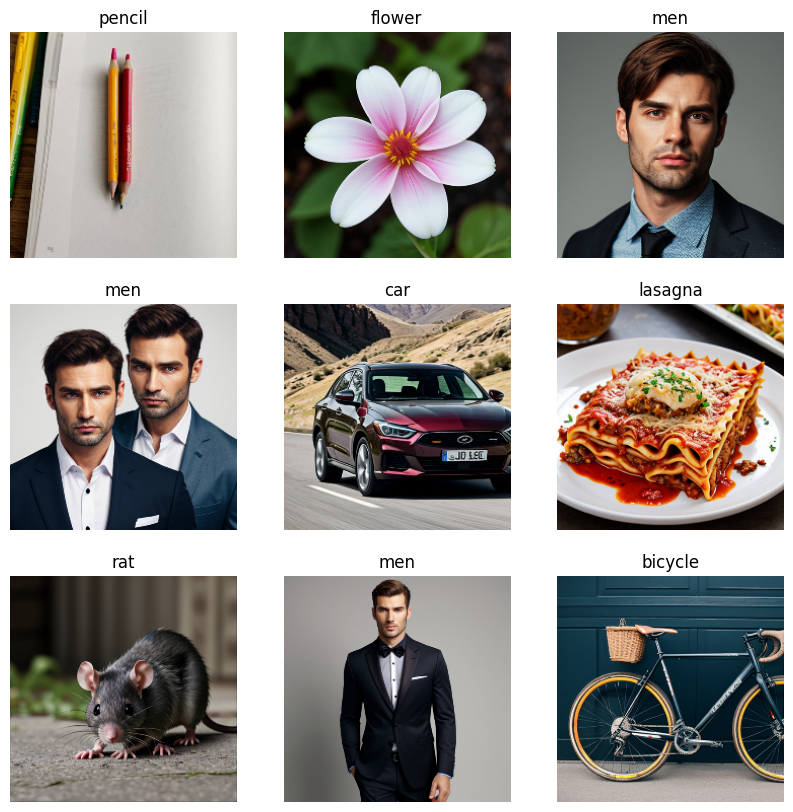

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Paramètres
IMG_SIZE = 224  # Taille optimale pour EfficientNet
BATCH_SIZE = 32

# Chargement du jeu de données
full_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='int',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Obtention des noms de classes
class_names = full_dataset.class_names
print(f"Nombre de classes : {len(class_names)}")
print("Classes :", class_names)

# Division du jeu de données (80% entraînement, 10% validation, 10% test)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size).take(val_size)
test_dataset = full_dataset.skip(train_size + val_size).take(test_size)

# Optimisation des pipelines de données
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("✅ Données chargées et optimisées.")

# Visualisation d'un échantillon
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 4. Architecture du Modèle {#model}

### 🏗️ Architecture Choisie: EfficientNetV2B0

**Pourquoi EfficientNetV2B0 ?**
- ✅ **Efficacité**: Meilleur rapport performance/taille
- ✅ **Transfer Learning**: Pré-entraîné sur ImageNet
- ✅ **Vitesse**: Plus rapide que les versions précédentes
- ✅ **Précision**: Excellentes performances sur la classification

### 🔧 Composants du Modèle:
1. **Data Augmentation**: Rotation et flip horizontal/vertical
2. **Base Model**: EfficientNetV2B0 (frozen)
3. **Global Average Pooling**: Réduction de dimensionnalité
4. **Dropout**: Régularisation (20%)
5. **Dense Layer**: Classification finale (32 classes)


In [13]:
from tensorflow.keras import layers, models

# Couche d'augmentation de données
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
], name="data_augmentation")

# Chargement du modèle de base
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Construction du modèle final
num_classes = len(class_names)
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        40,992 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,960,304 (22.74 MB)

 Trainable params: 40,992 (160.12 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

## 5. Entraînement du Modèle {#training}

### ⚙️ Configuration de l'Entraînement:
- **Optimiseur**: Adam (lr=0.001)
- **Loss Function**: Sparse Categorical Crossentropy
- **Métriques**: Accuracy
- **Early Stopping**: Patience de 5 epochs
- **Epochs Max**: 50

### 📈 Stratégie:
1. **Phase 1**: Entraînement avec base model frozen
2. **Callbacks**: Arrêt anticipé pour éviter le sur-apprentissage


In [14]:
# Callback pour l'arrêt anticipé
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entraînement
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

print("✅ Entraînement terminé.")

Epoch 1/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.7948 - loss: 1.0701 - val_accuracy: 0.9984 - val_loss: 0.0592
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9932 - loss: 0.0508 - val_accuracy: 0.9992 - val_loss: 0.0240
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9962 - loss: 0.0278 - val_accuracy: 0.9992 - val_loss: 0.0142
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9963 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.0095
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9974 - loss: 0.0141 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9977 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9981 - loss: 0.0092 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9981 - loss: 0.0093 - val_acc


## 6. Évaluation des Performances {#evaluation}

### 📊 Métriques d'Évaluation:
- **Accuracy sur le test set**
- **Rapport de classification détaillé**
- **Matrice de confusion**
- **Métriques par classe**: Precision, Recall, F1-Score


38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 1.0000 - loss: 6.7421e-04

🎯 Précision sur le jeu de test : 100.00%


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step

📊 Rapport de Classification :
              precision    recall  f1-score   support

     bicycle       1.00      1.00      1.00        31
        bird       1.00      1.00      1.00        28
       bread       1.00      1.00      1.00        31
         car       1.00      1.00      1.00        40
         cat       1.00      1.00      1.00        38
         dog       1.00      1.00      1.00        52
    elephant       1.00      1.00      1.00        16
        fish       1.00      1.00      1.00        40
      flower       1.00      1.00      1.00        31
        frog       1.00      1.00      1.00        29
   hamburger       1.00      1.00      1.00        30
       horse       1.00      1.00      1.00        20
     lasagna       1.00      1.00      1.00        39
        lion       1.00      1.00      1.00        27
         men       1.00      1.00      1.00       118
      monkey       1.00      1.00      1.00        33
       moo

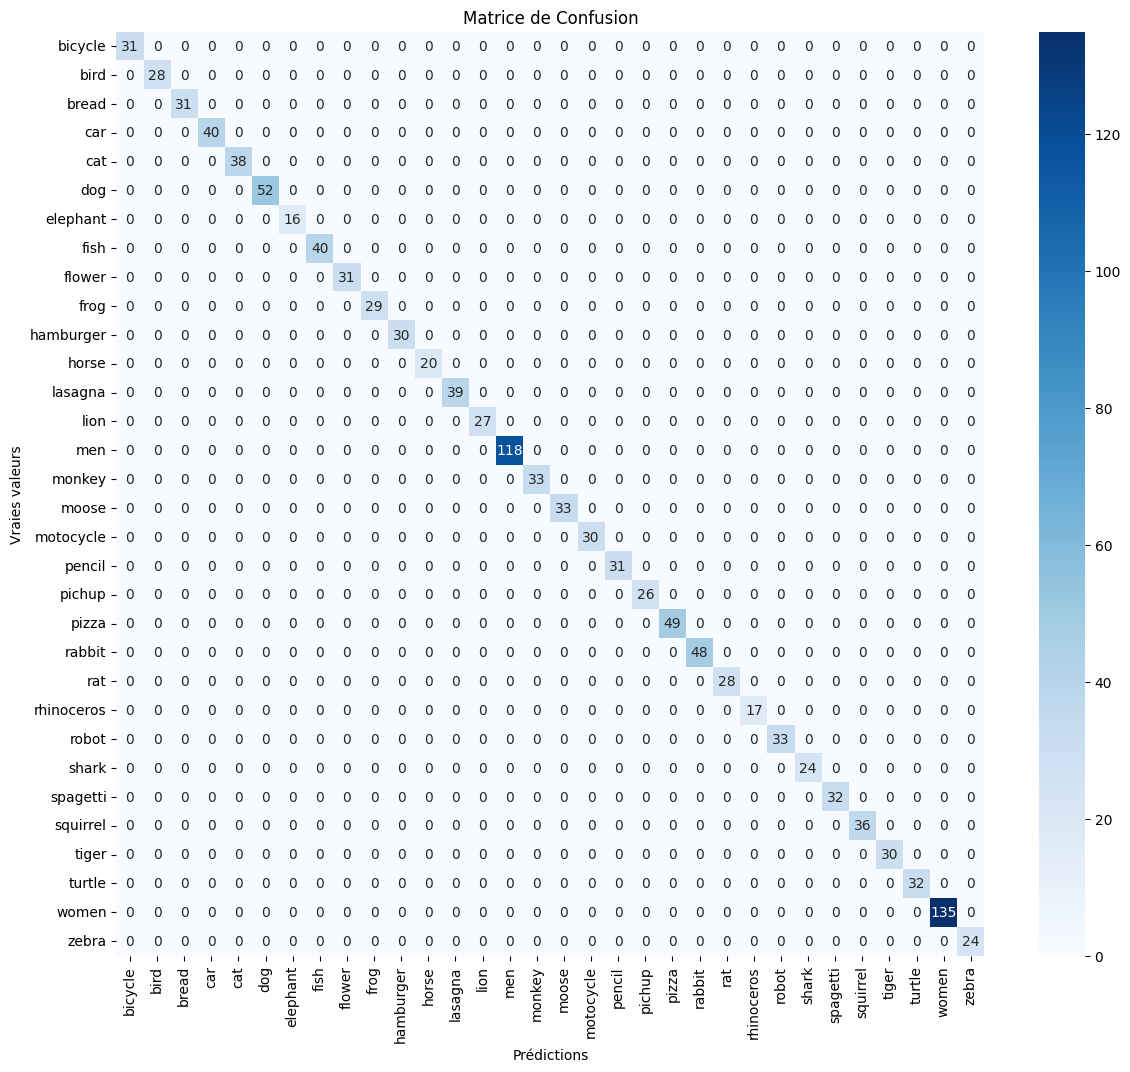

In [15]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Évaluation sur le jeu de test
loss, accuracy = model.evaluate(test_dataset)
print(f"\n🎯 Précision sur le jeu de test : {accuracy:.2%}")

# Prédictions et vraies valeurs
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([labels for images, labels in test_dataset], axis=0)

# Rapport de classification
print("\n📊 Rapport de Classification :")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Matrice de confusion
print("\n📊 Matrice de Confusion :")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

## 7. Sauvegarde du Modèle {#save}

Le modèle entraîné est sauvegardé au format Keras (.keras) pour une réutilisation future.


In [16]:
# Sauvegarde du modèle
model.save('Pipeline-Classification-MLOps\models\image_classifier_model.keras')

print("✅ Modèle sauvegardé sous le nom 'image_classifier_model.keras'.")

✅ Modèle sauvegardé sous le nom 'image_classifier_model.keras'.


## 8. Tests de Prédiction en Production {#prediction}

### 🧪 Tests de Validation:
1. **Tests de Base**: Images évidentes (pizza, éléphant)
2. **Tests de Robustesse**: Classes similaires (lion vs tigre)
3. **Tests Hors Distribution**: Images inconnues du modèle

### 🎯 Objectif des Tests:
- Vérifier la capacité de généralisation
- Identifier les potentielles confusions entre classes
- Tester la robustesse face à des images nouvelles


In [22]:
import tensorflow as tf
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import os

# --- Configuration ---
MODEL_PATH = "Pipeline-Classification-MLOps\models\image_classifier_model.keras"
IMG_SIZE = 224

# --- URLs pour les tests ---
# Tests "simples"
IMAGE_URL_PIZZA = "https://upload.wikimedia.org/wikipedia/commons/a/a3/Eq_it-na_pizza-margherita_sep2005_sml.jpg"
IMAGE_URL_CAR = "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/2019_Toyota_Corolla_Icon_Tech_VVT-i_Hybrid_1.8.jpg/1920px-2019_Toyota_Corolla_Icon_Tech_VVT-i_Hybrid_1.8.jpg"
IMAGE_URL_ELEPHANT = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Elephant_Diversity.jpg/1920px-Elephant_Diversity.jpg"

# Tests de robustesse (classes similaires)
IMAGE_URL_LION = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Lion_waiting_in_Namibia.jpg/1280px-Lion_waiting_in_Namibia.jpg"
IMAGE_URL_LASAGNA = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/Lasagne_-_stonesoup.jpg/1280px-Lasagne_-_stonesoup.jpg"
IMAGE_URL_SPAGHETTI = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/Spaghetti-al-pomodoro-basilico.jpg/1920px-Spaghetti-al-pomodoro-basilico.jpg"
IMAGE_URL_PICKUP = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/2019_Ford_Ranger_Wildtrak_3.2_4x4_Automatic_facelift.jpg/1920px-2019_Ford_Ranger_Wildtrak_3.2_4x4_Automatic_facelift.jpg"

# --- URLS CORRIGÉES ---
IMAGE_URL_TIGER = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Walking_tiger_female.jpg/1920px-Walking_tiger_female.jpg"
IMAGE_URL_LAPTOP = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Apple_MacBook_Pro_14_in_M1_Max_and_M1_Pro_2021.jpg/1920px-Apple_MacBook_Pro_14_in_M1_Max_and_M1_Pro_2021.jpg"
# -------------------------


# --- Liste des classes ---
CLASS_NAMES = [
    'Bicycle', 'Bird', 'Bread', 'Car', 'Cat', 'Dog', 'Elephant', 'Fish',
    'Flower', 'Frog', 'Hamburger', 'Horse', 'Lasagna', 'Lion', 'Men',
    'Monkey', 'Moose', 'Motorcycle', 'Pencil', 'Pickup', 'Pizza', 'Rabbit',
    'Rat', 'Rhinoceros', 'Robot', 'Shark', 'Spaghetti', 'Squirrel', 'Tiger',
    'Turtle', 'Women', 'Zebra'
]

def preprocess_image(image):
    """Prétraite une image pour la prédiction."""
    image = image.convert("RGB")
    image = image.resize((IMG_SIZE, IMG_SIZE))
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

def predict_on_image(model, image_url, test_type=""):
    """Télécharge une image depuis une URL, la traite et affiche la prédiction."""
    print("-" * 40)
    if test_type:
        print(f"🔬 {test_type}")
    print(f"🌐 URL : {image_url[:70]}...")

    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(image_url, headers=headers)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))

        processed_image = preprocess_image(image)

        print("🧠 Prédiction en cours...")
        predictions = model.predict(processed_image, verbose=0)
        scores = tf.nn.softmax(predictions[0])

        predicted_class_index = np.argmax(scores)
        predicted_class_name = CLASS_NAMES[predicted_class_index]
        confidence = np.max(scores) * 100

        print("\n--- RÉSULTAT DE LA PRÉDICTION ---")
        print(f"🎯 Classe prédite : {predicted_class_name}")
        print(f"💯 Confiance : {confidence:.2f}%")

    except Exception as e:
        print(f"❌ Une erreur est survenue : {e}")
    finally:
        print("-" * 40)


def main():
    """Fonction principale pour charger le modèle et lancer les tests."""
    print(f"--- Début du test pour le modèle : {MODEL_PATH} ---")

    if not os.path.exists(MODEL_PATH):
        print(f"❌ Erreur : Le fichier du modèle '{MODEL_PATH}' n'a pas été trouvé.")
        return

    try:
        print("🔄 Chargement du modèle...")
        model = tf.keras.models.load_model(MODEL_PATH)
        print("✅ Modèle chargé avec succès.")
    except Exception as e:
        print(f"❌ Erreur lors du chargement du modèle : {e}")
        return

    # --- SÉRIE DE TESTS ---
    print("\n\n--- Tests de Base ---")
    predict_on_image(model, IMAGE_URL_PIZZA)
    predict_on_image(model, IMAGE_URL_ELEPHANT)

    print("\n\n--- Tests de Robustesse : Classes Similaires ---")
    predict_on_image(model, IMAGE_URL_LION, "Image attendue : Lion")
    predict_on_image(model, IMAGE_URL_TIGER, "Image attendue : Tigre")
    predict_on_image(model, IMAGE_URL_LASAGNA, "Image attendue : Lasagnes")
    predict_on_image(model, IMAGE_URL_SPAGHETTI, "Image attendue : Spaghetti")
    predict_on_image(model, IMAGE_URL_CAR, "Image attendue : Voiture")
    predict_on_image(model, IMAGE_URL_PICKUP, "Image attendue : Camionnette")

    print("\n\n--- Test Hors Distribution ---")
    predict_on_image(model, IMAGE_URL_LAPTOP, "Image attendue : INCONNUE")


if __name__ == "__main__":
    main()

--- Début du test pour le modèle : /content/drive/MyDrive/TP/image_classifier_model.keras ---
🔄 Chargement du modèle...
✅ Modèle chargé avec succès.


--- Tests de Base ---
----------------------------------------
🌐 URL : https://upload.wikimedia.org/wikipedia/commons/a/a3/Eq_it-na_pizza-mar...
🧠 Prédiction en cours...

--- RÉSULTAT DE LA PRÉDICTION ---
🎯 Classe prédite : Lasagna
💯 Confiance : 7.55%
----------------------------------------
----------------------------------------
🌐 URL : https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Elephant_Div...
🧠 Prédiction en cours...

--- RÉSULTAT DE LA PRÉDICTION ---
🎯 Classe prédite : Elephant
💯 Confiance : 8.02%
----------------------------------------


--- Tests de Robustesse : Classes Similaires ---
----------------------------------------
🔬 Image attendue : Lion
🌐 URL : https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Lion_waiting...
🧠 Prédiction en cours...

--- RÉSULTAT DE LA PRÉDICTION ---
🎯 Classe prédite : Lion
💯 